In [1]:
# ===============================================================
# FINAL STAGE: MODEL TRAINING, EVALUATION, AND PRESENTATION PREP
# ===============================================================
#
# We have:
# - Defined our unit of analysis (country-month)
# - Engineered time-based features
# - Defined a statistical target (IQR-based extreme month)
#
# Now we will:
# 1) Finalize feature set (test for multicolinearity)
# 2) Train logistic regression
# 3) Evaluate performance
# 4) Interpret coefficients
# 5) Prepare insights for presentation


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ---------------------------------------------------------------
# STEP 1: Load the finalized country-month dataset
# ---------------------------------------------------------------
# Make sure:
# - Only stable time period is included (e.g., 2021+)
# - All engineered features exist
# - No missing values remain

country_month = pd.read_csv(
    "processed/processed_Asia-Pacific_up_to_2026-01-31.csv"
)

country_month.head(10)

,COUNTRY,YEAR_MONTH,total_events,total_fatalities,is_outlier_iqr,lag_1_events,event_change,rolling_3m
0,Afghanistan,2021-03,942,2135,1,1042.0,-100.0,1058.000000
1,Afghanistan,2021-04,1102,3453,1,942.0,160.0,1028.666667
2,Afghanistan,2021-05,1652,7527,1,1102.0,550.0,1232.000000
3,Afghanistan,2021-06,1381,8042,1,1652.0,-271.0,1378.333333
4,Afghanistan,2021-07,1297,10896,1,1381.0,-84.0,1443.333333
5,Afghanistan,2021-08,412,3339,0,1297.0,-885.0,1030.000000
6,Afghanistan,2021-09,179,193,0,412.0,-233.0,629.333333
7,Afghanistan,2021-10,226,527,0,179.0,47.0,272.333333
8,Afghanistan,2021-11,165,194,0,226.0,-61.0,190.000000
9,Afghanistan,2021-12,198,189,0,165.0,33.0,196.333333


In [4]:
# ------------------------------------------------------------
# STEP 2: Define X (features) and y (label)
# ------------------------------------------------------------
# Features we are using:
feature_cols = ["total_events", "total_fatalities", "event_change", "rolling_3m"]

# Target label:
target_col = "is_outlier_iqr"

# Create X and y
X = country_month[feature_cols].copy()
y = country_month[target_col].copy()

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

X shape: (1624, 4)
y distribution:
 is_outlier_iqr
0    1389
1     235
Name: count, dtype: int64


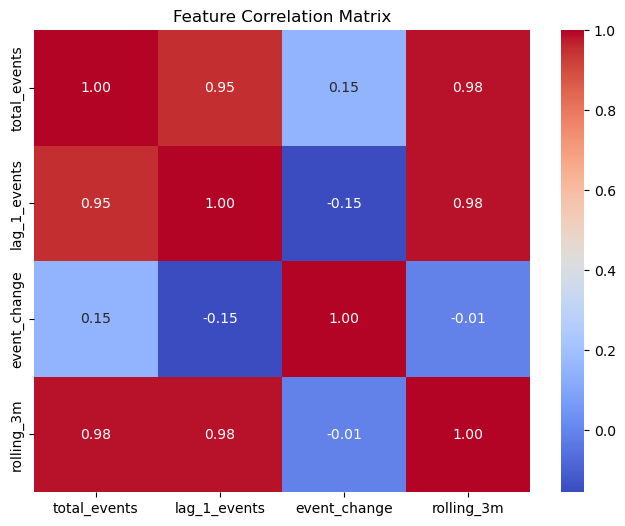

In [5]:
# ============================================================
# STEP 3: Test for Multicollinearity Between Features
# ============================================================
#
# Purpose:
# We check if features are highly correlated.
# High correlation (> 0.9) can make coefficients unstable.
# It affects interpretation more than predictive performance.
# Compute correlation matrix

features = country_month[
    [
        "total_events",
        "lag_1_events",
        "event_change",
        "rolling_3m"
    ]
]

corr_matrix = features.corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Feature Correlation Matrix")
plt.show()

#Answer:
# The heat map below shows correlation b/w all predictive features.
# Rolling_3m has the highest correlation with both total_events and lag_1_events. Total_events and lag_1_events
# also have high correlation (0.95).
# I think a reasonable decision would be to drop one because having both will skew our interpretations.
# I would drop total_events because it is mathematically implied in event_change and lag_1_events.

In [6]:
# ============================================================
# STEP 4: Scale Features
# ============================================================
#
# Purpose:
# Logistic regression performs better when features are on similar scales.
# StandardScaler transforms each feature to:
# mean = 0, std = 1

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [7]:
# ------------------------------------------------------------
# STEP 5: Train/Test Split
# ------------------------------------------------------------
# TODO: Import train_test_split
# TODO: Split into train/test (80/20), random_state=42
# TODO: Use stratify=y to preserve class balance

from sklearn.model_selection import train_test_split

X = country_month[["lag_1_events", "event_change", "rolling_3m"]]
y = country_month["is_outlier_iqr"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Resource:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [8]:
# ============================================================
# STEP 6: Apply Scaling (Correctly)
# ============================================================
#
# Fit scaler ONLY on training data
# Then transform both training and test sets

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# ------------------------------------------------------------
# STEP 7: Train Logistic Regression
# ------------------------------------------------------------
# TODO:
# 1) Import LogisticRegression
# 2) Create model with max_iter=1000
# 3) Optional: add class_weight="balanced" if y is imbalanced
# 4) Fit model on X_train_scaled and y_train

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train_scaled, y_train)

# Resource:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [10]:
# ------------------------------------------------------------
# STEP 8: Evaluate Performance
# ------------------------------------------------------------
# TODO:
# 1) Import confusion_matrix, classification_report, roc_auc_score
# 2) Predict labels on X_test_scaled
# 3) Predict probabilities on X_test_scaled
# 4) Print confusion matrix
# 5) Print classification report
# 6) Print ROC-AUC score

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred = model.predict(X_test_scaled) #2

y_prob = model.predict_proba(X_test_scaled)[:, 1]  #3

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))  #4

print("\nClassification Report:\n", classification_report(y_test, y_pred))  #5

roc = roc_auc_score(y_test, y_prob)
print("\nROC-AUC Score:\n", roc)  #6

# Confusion matrix:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#
# Classification report:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#
# ROC AUC:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

Confusion Matrix:
 [[271   7]
 [  0  47]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       278
           1       0.87      1.00      0.93        47

    accuracy                           0.98       325
   macro avg       0.94      0.99      0.96       325
weighted avg       0.98      0.98      0.98       325


ROC-AUC Score:
 1.0


In [11]:
# ------------------------------------------------------------
# STEP 9: Interpret Coefficients
# ------------------------------------------------------------
# Purpose:
# Coefficients tell us how each feature influences probability of extreme conflict.
#
# TODO:
# 1) Create a dataframe with columns: feature, coefficient
# 2) Sort by absolute value (strongest effects)
# 3) Print the table

coefficient_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]  #1
})

coefficient_df["abs_coefficient"] = np.abs(coefficient_df["coefficient"])

coefficient_df = coefficient_df.sort_values(
    by="abs_coefficient",
    ascending=False  #2
)

coefficient_df = coefficient_df.drop(columns="abs_coefficient")

print(coefficient_df)  #3

        feature  coefficient
0  lag_1_events     4.555046
2    rolling_3m     4.240508
1  event_change     2.261958


In [12]:
# Escalation (lag_1_events) strongly influences the probability of extreme conflict.